# Import Library

In [1]:
# load data
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# load/save model
import pickle

### Define common pickle method

In [2]:
def load_file_pickle(filename):
    file_pickle = pickle.load(open(filename, 'rb'))
    return file_pickle

def save_file_pickle(data, filename):
    pickle.dump(data, open(filename, 'wb'))

#### Constant variable

In [3]:
BOW_FILE_PICKLE = "bow_dictionary.pkl"
SCALER_WS_FILE_PICKLE = "scaler_with_sift.pkl"
SCALER_WOS_FILE_PICKLE = "scaler_without_sift.pkl"
SVM_WS_FILE_PICKLE = "svm_with_sift_model.pkl"
SVM_WOS_FILE_PICKLE = "svm_without_sift_model.pkl"

# Load Data

- input: -
- output: `raw_X, raw_y`

In [4]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = os.listdir(path)
    images = np.array([import_image(path + '/' + file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [5]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

raw_X = np.empty((0, 224, 224, 3), np.uint8)
raw_y = np.empty((0))

folder_path = "../Dataset/phiard_selected/" # for local used
# folder_path = "drive/MyDrive/Skripsi/Repos/Dataset/phiard_selected/" # for drive used

for character in hanacaraka:
    dataset_path = folder_path + character

    temp_X, temp_y = import_data(character, dataset_path)

    print("Size of", character, ":", temp_X.shape[0])
    
    raw_X = np.append(raw_X, temp_X, axis=0)
    raw_y = np.append(raw_y, temp_y, axis=0)


Size of ba : 21
Size of ca : 21
Size of da : 21
Size of dha : 21
Size of ga : 21
Size of ha : 21
Size of ja : 21
Size of ka : 21
Size of la : 21
Size of ma : 21
Size of na : 21
Size of nga : 21
Size of nya : 21
Size of pa : 21
Size of ra : 21
Size of sa : 21
Size of ta : 21
Size of tha : 21
Size of wa : 21
Size of ya : 21


In [6]:
# Ukuran keseluruhan data
print("Number of data:", raw_X.shape[0])
print("Image dimension:", raw_X[0].shape)

Number of data: 420
Image dimension: (224, 224, 3)


### Visualize Raw Data

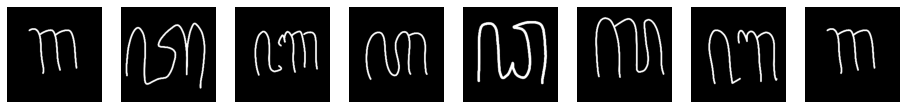

In [7]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(raw_X[np.random.randint(0, raw_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

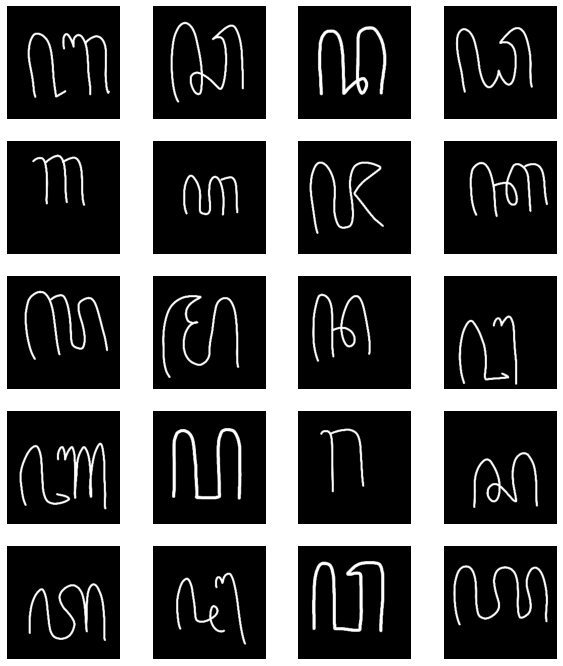

In [8]:
fig = plt.figure(figsize=(10, 12))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img = np.array(raw_X[i*20, :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Augmantation & Preparation Data

- input: `raw_X, raw_y`
- output: `X, y`

List Augmented :
1. Rotate 30 CCW
2. Rotate 15 CCW + Zoom out
3. Rotate 15 CW + Zoom out
4. Rotate 30 CW
5. Shear Left
6. Shear Right
7. Normal

List Preprocessing :
1. Resizing (192x192)
2. Grayscaling
3. Equalization

### Augmented Method

In [9]:
# Augmented Method
def rotate(img, degree):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), degree, 1.0)
    img_rotated = cv2.warpAffine(img, M, (w, h))
    return img_rotated

def zoom_out(img, zoom_scale):
    img_zoom = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    h, w = img.shape[0]/zoom_scale, img.shape[1]/zoom_scale
    h, w = int(h), int(w)
    x, y = (img.shape[0]-w)//2, (img.shape[1]-h)//2
    img_resize = cv2.resize(img, (h, w), interpolation = cv2.INTER_AREA)

    img_zoom[x:w+x, y:h+y] = img_resize
    return img_zoom

def shear(img, x, y):
    rows, cols = img.shape
    M = np.float32([[1, x, 0],
                    [y, 1, 0]])
    sheared_img = cv2.warpAffine(img, M, (cols, rows))
    return sheared_img

### Image Preprocessing Method

In [10]:
# Preprocessing Image
def equalizing(img):
    if (img.ndim == 3):
        b, g, r = cv2.split(img)
        red = cv2.equalizeHist(r)
        green = cv2.equalizeHist(g)
        blue = cv2.equalizeHist(b)
        img = cv2.merge((blue, green, red))
    else:
        img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [11]:
# Generate augmentation and preprocessing data
size = 192
def dataset_aug_generator_prep(ori_img, size):
    ori_img = resizing(ori_img, size)
    ori_img = grayscaling(ori_img)
    
    ori_img = zoom_out(ori_img, 1.15)
    img_r_30_ccw = rotate(ori_img, 30)
    img_r_30_cw = rotate(ori_img, -30)
    img_r_15_ccw_z = rotate(zoom_out(ori_img, 1.3), 15)
    img_r_15_cw_z = rotate(zoom_out(ori_img, 1.3), -15)
    img_s_left = shear(ori_img, -0.15, -0.15)
    img_s_right = shear(ori_img, 0.15, 0.15)
    
    result_aug = [ori_img, img_r_30_ccw, img_r_30_cw, img_r_15_ccw_z, img_r_15_cw_z, img_s_left, img_s_right]
    for idx, item_img in enumerate(result_aug):
        result_aug[idx] = equalizing(result_aug[idx])
    return result_aug

#### test result image after generate augmentation and preprocessing

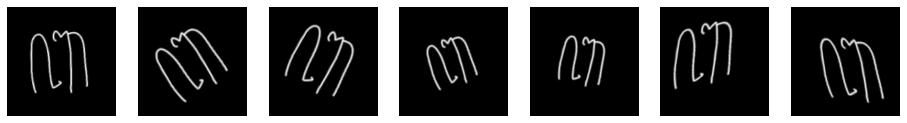

In [12]:
test_img_aug = dataset_aug_generator_prep(raw_X[0], size)

fig = plt.figure(figsize=(16, 4))
columns = 7
rows = 1
for i in range(1, columns*rows + 1):
    img = test_img_aug[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

## Generate Aug & Prep Image on All Raw Data

In [13]:
X = np.empty((0, size, size), np.uint8)
y = np.empty((0))

for idx, img in enumerate(raw_X):
    img_aug = dataset_aug_generator_prep(img, size)
    
    for item_img in img_aug:
        X = np.append(X, [item_img], axis=0)
        y = np.append(y, [raw_y[idx]], axis=0)

In [14]:
print("Result X data dimension:", X.shape)
print("Result y data dimension:", y.shape)

Result X data dimension: (2940, 192, 192)
Result y data dimension: (2940,)


### Visualize Result Data

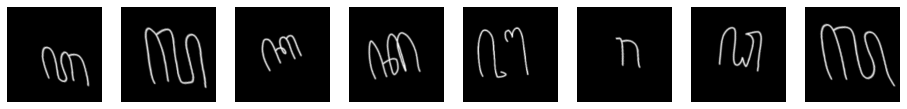

In [15]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X`
- output: `X_feature`

### Extract SIFT Descriptors 

In [133]:
def extract_sift_features(list_image):
    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def combine_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [134]:
image_descriptors = extract_sift_features(X)

In [135]:
all_descriptors = combine_all_descriptors(image_descriptors)
print("Number of keypoint descriptor:", all_descriptors.shape)

Number of keypoint descriptor: (193416, 128)


### Create BOW of Descriptor Using Cluster

In [136]:
def kmeans_bow(all_descriptors, num_cluster):
    if not os.path.isfile(BOW_FILE_PICKLE):
        kmeans = KMeans(n_clusters = num_cluster, verbose=1, random_state=42)
        kmeans.fit(all_descriptors)

        bow_dict = kmeans.cluster_centers_
            
        save_file_pickle(bow_dict, BOW_FILE_PICKLE)
    else:
        bow_dict = load_file_pickle(BOW_FILE_PICKLE)

    return bow_dict

In [137]:
num_cluster = 750
bow = kmeans_bow(all_descriptors, num_cluster)

Initialization complete
Iteration 0, inertia 2612717824.0
Iteration 1, inertia 1984042496.0
Iteration 2, inertia 1936021504.0
Iteration 3, inertia 1917251328.0
Iteration 4, inertia 1907810432.0
Iteration 5, inertia 1901338880.0
Iteration 6, inertia 1896333824.0
Iteration 7, inertia 1892184960.0
Iteration 8, inertia 1888764800.0
Iteration 9, inertia 1885718272.0
Iteration 10, inertia 1883119232.0
Iteration 11, inertia 1881253632.0
Iteration 12, inertia 1879766528.0
Iteration 13, inertia 1878506112.0
Iteration 14, inertia 1877414528.0
Iteration 15, inertia 1876530944.0
Iteration 16, inertia 1875799808.0
Iteration 17, inertia 1875080832.0
Iteration 18, inertia 1874306432.0
Iteration 19, inertia 1873579904.0
Iteration 20, inertia 1873070336.0
Iteration 21, inertia 1872632064.0
Iteration 22, inertia 1872301696.0
Iteration 23, inertia 1872010624.0
Iteration 24, inertia 1871723904.0
Iteration 25, inertia 1871430656.0
Iteration 26, inertia 1871092864.0
Iteration 27, inertia 1870849024.0
Iterat

### Create Features From BOW

In [138]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [139]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 750)


# Classification With SIFT

- input: `X_feature, y`
- output: -

In [140]:
# normalization
scaler = MinMaxScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [141]:
# Just save normalization function for future used
save_file_pickle(scaler, SCALER_WS_FILE_PICKLE)

In [142]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

Size of training: 2499
Size of testing: 441


### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'scale', 0.001, 0.0015, 0.0025, 0.003 \]
    - 'scale' = 1 / nfeatures * x.var()

#### Load model

In [143]:
# Just load model without re-training if you want
svm_ws = load_file_pickle(SVM_WS_FILE_PICKLE)

In [144]:
# create parameter tuning
_var = X_train.var()
_scale = round(1 / (num_cluster * X_train.var()), 5)
_dist = round(_scale * 2 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)

0.10655
0.00213
[0.10229, 0.10442, 0.10655, 0.10868, 0.11081]


In [145]:
svm_ws_params = {
    'C': _c,
    'gamma': _gamma
}
svm_ws = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_ws_params, cv=5, verbose=3)

In [146]:
svm_ws.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=1, gamma=0.10229;, score=0.906 total time=   7.6s
[CV 2/5] END ................C=1, gamma=0.10229;, score=0.884 total time=   7.7s
[CV 3/5] END ................C=1, gamma=0.10229;, score=0.932 total time=   7.7s
[CV 4/5] END ................C=1, gamma=0.10229;, score=0.896 total time=   7.6s
[CV 5/5] END ................C=1, gamma=0.10229;, score=0.920 total time=   7.6s
[CV 1/5] END ................C=1, gamma=0.10442;, score=0.906 total time=   7.5s
[CV 2/5] END ................C=1, gamma=0.10442;, score=0.884 total time=   7.6s
[CV 3/5] END ................C=1, gamma=0.10442;, score=0.932 total time=   7.7s
[CV 4/5] END ................C=1, gamma=0.10442;, score=0.898 total time=   7.7s
[CV 5/5] END ................C=1, gamma=0.10442;, score=0.920 total time=   7.7s
[CV 1/5] END ................C=1, gamma=0.10655;, score=0.906 total time=   7.6s
[CV 2/5] END ................C=1, gamma=0.10655

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': [0.10229, 0.10442, 0.10655, 0.10868,
                                   0.11081]},
             verbose=3)

In [147]:
print("Best Model:", svm_ws.best_estimator_)
print("Best CV Score:", svm_ws.best_score_)

Best Model: SVC(C=10, gamma=0.10442, probability=True)
Best CV Score: 0.9223743486973948


#### All result score CV from tuning parameter SVM

In [148]:
cv_results_df = pd.DataFrame(svm_ws.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15_0.10442,"{'C': 15, 'gamma': 0.10442}",1,0.922374,0.011796
10_0.10442,"{'C': 10, 'gamma': 0.10442}",1,0.922374,0.011796
15_0.10229,"{'C': 15, 'gamma': 0.10229}",3,0.921974,0.011836
10_0.10229,"{'C': 10, 'gamma': 0.10229}",3,0.921974,0.011836
6_0.10442,"{'C': 6, 'gamma': 0.10442}",3,0.921974,0.012429
15_0.10655,"{'C': 15, 'gamma': 0.10655}",6,0.921574,0.011658
10_0.10655,"{'C': 10, 'gamma': 0.10655}",6,0.921574,0.011658
6_0.10229,"{'C': 6, 'gamma': 0.10229}",6,0.921574,0.012454
6_0.10655,"{'C': 6, 'gamma': 0.10655}",9,0.921174,0.012272


#### Save model

In [149]:
# Just save model for future used
save_file_pickle(svm_ws, SVM_WS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=3, gamma=0.0009)

In [150]:
y_pred = svm_ws.predict(X_test)

In [151]:
test = svm_ws.predict_proba(np.reshape(X_test[0], (1, -1)))
test

array([[3.47686371e-03, 1.41562165e-01, 4.67978457e-03, 2.66435686e-03,
        4.02169297e-04, 1.37191357e-03, 1.36067260e-03, 4.68336070e-03,
        2.98957925e-03, 1.12266748e-03, 8.36143463e-03, 1.48413285e-03,
        5.57142099e-03, 2.29233000e-04, 7.89746146e-05, 8.02350187e-01,
        1.66682882e-03, 7.68948948e-03, 4.79186628e-04, 7.77557867e-03]])

In [152]:
test_label = hanacaraka[test.argmax()]
test_label


'sa'

In [153]:
test_acc = round(test.max() * 100, 2)
test_acc

80.24

#### Heatmap result predict

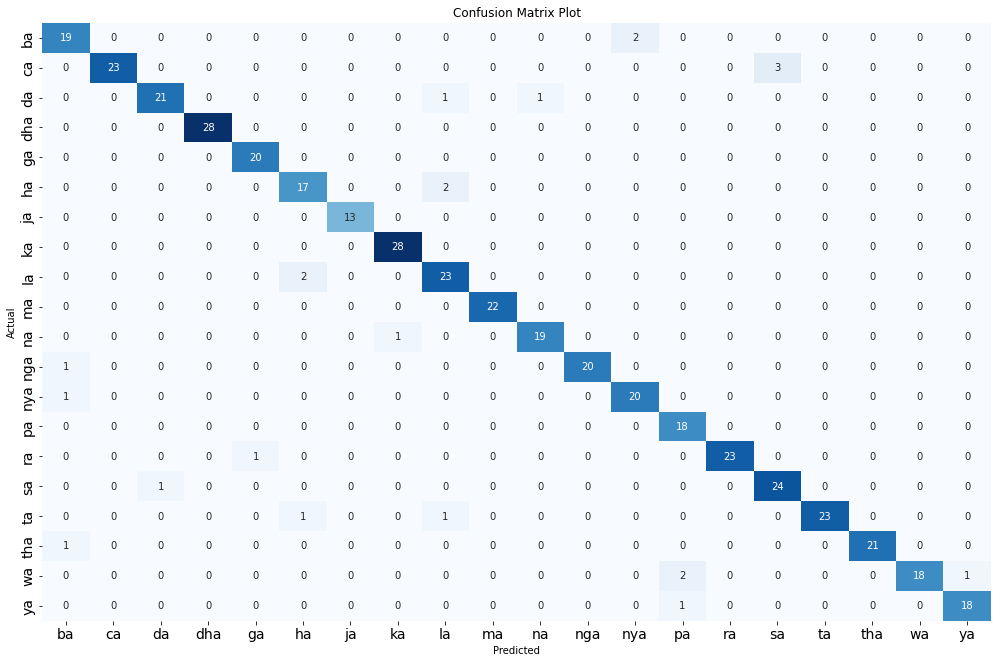

In [154]:
conf_ws = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_ws, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [155]:
class_rep_ws = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_ws)

Classification report result:
              precision    recall  f1-score   support

          ba       0.86      0.90      0.88        21
          ca       1.00      0.88      0.94        26
          da       0.95      0.91      0.93        23
         dha       1.00      1.00      1.00        28
          ga       0.95      1.00      0.98        20
          ha       0.85      0.89      0.87        19
          ja       1.00      1.00      1.00        13
          ka       0.97      1.00      0.98        28
          la       0.85      0.92      0.88        25
          ma       1.00      1.00      1.00        22
          na       0.95      0.95      0.95        20
         nga       1.00      0.95      0.98        21
         nya       0.91      0.95      0.93        21
          pa       0.86      1.00      0.92        18
          ra       1.00      0.96      0.98        24
          sa       0.89      0.96      0.92        25
          ta       1.00      0.92      0.96        

### Result Accuracy Score for SVM with SIFT

In [156]:
acc_ws = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_ws)

Accuracy score: 0.9478458049886621


# Note for Result SIFT With SVM

### Testing Scenario
- Img = \[ 64, 96, 128, 164, 192, 224 \]
  - Img prep = Greyscale, Equalization
- K = \[ 1000, 700, 500, 350, 240, 180 \]
- C = \[ 1, 3, 6, 10, 15\]
- G = \[ 'auto', 0.001, 0.0015, 0.0025, 0.003 \]

### Result:
- Img = (25,25), K = 180, SVM = 0.61
- Img = (28,28), K = 140, SVM = 0.59
- Img = (32,32), K = 140, SVM = 0.69
- Img = (64,64), K = 180, SVM = 0.89
- Img = (64,64), K = 240, SVM = .89:.90
- Img = (96,96), K = 240, SVM = .89:.89
- Img = (128,128), K = 140, SVM = .87:.89
- Img = (128,128), K = 180, SVM = .88:.93
- Img = (128,128), K = 240, SVM = .90:.95
- Img = (128,128), K = 350, SVM = .91:.94
- Img = (128,128), K = 500, SVM = .92:.95
- Img = (128,128), K = 700, SVM = .92:.94
- Img = (128,128), K = 1000, SVM = .92:.94
- Img = (164,164), K = 240, SVM = .90:.91
- Img = (192,192), K = 240, SVM = .90:.92
- Img = (224,224), K = 240, SVM = .88:.90


======================================

- Img = (128,128), K = 60, KNN = 0.69, SVM = 0.82
- Img = (128,128), K = 80, KNN = 0.71, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.76, SVM = 0.90
- Img = (128,128), K = 120, KNN = 0.74, SVM = 0.91
- Img = (128,128), K = 140, KNN = 0.78, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.76, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.75, SVM = 0.92
- Img = (128,128), K = 200, KNN = 0.75, SVM = 0.94 (G,T) / 0.92 (G,E) / 0.86 (G,E,T) / 0.86 (G,T,E)
- Img = (128,128), K = 240, KNN = 0.76, SVM = 0.96 (G,T) / 0.90:0.94 (G,E)
- Img = (128,128), K = 350, KNN = 0.75, SVM = 0.94
- Img = (128,128), K = 500, KNN = 0.76, SVM = 0.97
- Img = (128,128), K = 700, KNN = 0.71, SVM = 0.95
- Img = (128,128), K = 1000, KNN = 0.63, SVM = 0.95


### Conclusion
- Best image : 128x128
  1. 128: .90:.94
  2. 192: .90:.92
  3. 164: .90:.91
  4. 64: .89:.90
  5. 96: .89:.89
  6. 224: .88:.90
- Best K val : 500 
  1. 500 : .92:.95
  2. 240 : .90:.95
  3. 700 : .92:.94
  4. 1000 : .92:.94
  5. 350 : .91:.94
  6. 180 : .88:.93
- Best C val : 6
- Best G val : 0.0015

# Classification Without SIFT

- input: `X, y`
- output: -

### Image Preprocessing

Data should be resized for lower time consumtion training

In [157]:
# new_X = X
new_X = []

for i in range(X.shape[0]) :
    new_X.append(equalizing(resizing(X[i], 32)))
    
new_X = np.array(new_X, dtype=np.uint8)

### Visualize Result Data

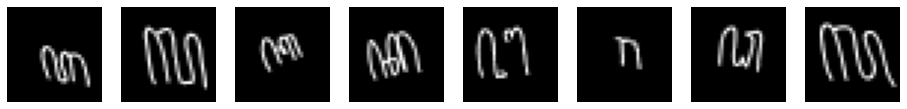

In [158]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(new_X[np.random.randint(0, new_X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.show()

### Preprocessing

In [159]:
# reshape data
X_feature = np.reshape(new_X, (new_X.shape[0], new_X[0].shape[0]*new_X[0].shape[1]))
print("Feature X data dimension:", X_feature.shape)

Feature X data dimension: (2940, 1024)


In [160]:
# normalization
scaler = MinMaxScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

#### Save scaler

In [161]:
# Just save normalization function for future used
save_file_pickle(scaler, SCALER_WOS_FILE_PICKLE)

In [162]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Size of training:", X_train.shape[0])
print("Size of testing:", X_test.shape[0])

Size of training: 2499
Size of testing: 441


### SVM

Using GridSearchCV for tuning parameter, with scenario:
- 'C': \[ 1, 3, 6, 10, 15 \]
- 'gamma': \[ 'scale', 0.0008, 0.001, 0.0015, 0.0018 \]
    - 'scale' = 1 / nfeatures * x.var()

#### Load model

In [163]:
# Just load model without re-training if you want
svm_wos = load_file_pickle(SVM_WOS_FILE_PICKLE)

In [171]:
# create parameter tuning
_var = X_train.var()
_scale = round(1 / (1024 * X_train.var()), 5)
_dist = round(_scale * 2 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)

0.02359
0.00047
[0.02265, 0.02312, 0.02359, 0.02406, 0.02453]


In [172]:
svm_wos_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': _gamma,
}
svm_wos = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wos_params, cv=5, verbose=3)

In [173]:
svm_wos.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=1, gamma=0.02265;, score=0.444 total time=  10.8s
[CV 2/5] END ................C=1, gamma=0.02265;, score=0.456 total time=  10.9s
[CV 3/5] END ................C=1, gamma=0.02265;, score=0.428 total time=  10.6s
[CV 4/5] END ................C=1, gamma=0.02265;, score=0.448 total time=  10.4s
[CV 5/5] END ................C=1, gamma=0.02265;, score=0.453 total time=  10.6s
[CV 1/5] END ................C=1, gamma=0.02312;, score=0.446 total time=  10.4s
[CV 2/5] END ................C=1, gamma=0.02312;, score=0.460 total time=  10.2s
[CV 3/5] END ................C=1, gamma=0.02312;, score=0.430 total time=  10.2s
[CV 4/5] END ................C=1, gamma=0.02312;, score=0.448 total time=  10.2s
[CV 5/5] END ................C=1, gamma=0.02312;, score=0.455 total time=  10.1s
[CV 1/5] END ................C=1, gamma=0.02359;, score=0.448 total time=  10.1s
[CV 2/5] END ................C=1, gamma=0.02359

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': [0.02265, 0.02312, 0.02359, 0.02406,
                                   0.02453]},
             verbose=3)

In [174]:
print("Best Model:", svm_wos.best_estimator_)
print("Best CV Score:", svm_wos.best_score_)

Best Model: SVC(C=3, gamma=0.02312, probability=True)
Best CV Score: 0.5118068136272544


#### All result score CV from tuning parameter SVM

In [175]:
cv_results_df = pd.DataFrame(svm_wos.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
3_0.02312,"{'C': 3, 'gamma': 0.02312}",1,0.511807,0.011146
3_0.02265,"{'C': 3, 'gamma': 0.02265}",2,0.511407,0.011168
3_0.02406,"{'C': 3, 'gamma': 0.02406}",3,0.510608,0.010277
3_0.02359,"{'C': 3, 'gamma': 0.02359}",4,0.510207,0.010708
15_0.02265,"{'C': 15, 'gamma': 0.02265}",5,0.509408,0.013446
10_0.02265,"{'C': 10, 'gamma': 0.02265}",5,0.509408,0.013446
6_0.02265,"{'C': 6, 'gamma': 0.02265}",5,0.509408,0.012712
6_0.02312,"{'C': 6, 'gamma': 0.02312}",8,0.509407,0.013052
3_0.02453,"{'C': 3, 'gamma': 0.02453}",9,0.509007,0.010085


#### Save model

In [176]:
# Just save model for future used
save_file_pickle(svm_wos, SVM_WOS_FILE_PICKLE)

### Predict Data Testing

Using SVC(C=10, gamma=0.0015)

In [177]:
y_pred = svm_wos.predict(X_test)

In [178]:
test = svm_wos.predict_proba(np.reshape(X_test[0], (1, -1)))
test

array([[0.02946752, 0.23183824, 0.02775901, 0.31137944, 0.00094679,
        0.00751722, 0.00715184, 0.00332082, 0.00752334, 0.00660019,
        0.00346781, 0.03252709, 0.00573433, 0.02163897, 0.00073125,
        0.04571245, 0.01097489, 0.14577527, 0.09633718, 0.00359637]])

#### Heatmap result predict

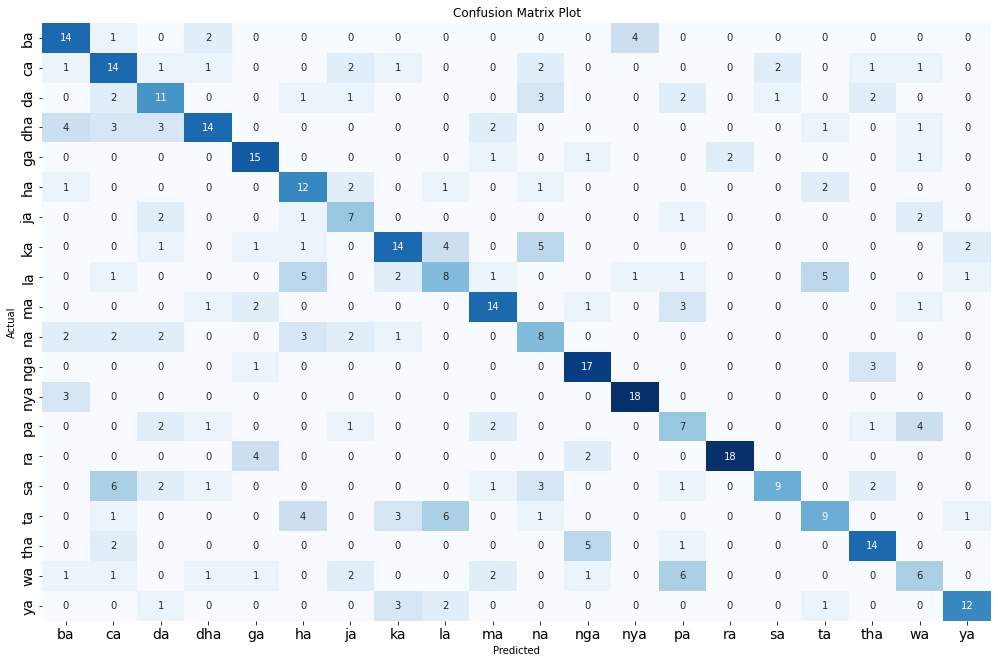

In [179]:
conf_wos = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=hanacaraka, index=hanacaraka)

plt.figure(figsize=(17,11))

res = sns.heatmap(conf_wos, annot=True, fmt="g", cmap="Blues", cbar=False)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [180]:
class_rep_wos = classification_report(y_test, y_pred)

print("Classification report result:")
print(class_rep_wos)

Classification report result:
              precision    recall  f1-score   support

          ba       0.54      0.67      0.60        21
          ca       0.42      0.54      0.47        26
          da       0.44      0.48      0.46        23
         dha       0.67      0.50      0.57        28
          ga       0.62      0.75      0.68        20
          ha       0.44      0.63      0.52        19
          ja       0.41      0.54      0.47        13
          ka       0.58      0.50      0.54        28
          la       0.38      0.32      0.35        25
          ma       0.61      0.64      0.62        22
          na       0.35      0.40      0.37        20
         nga       0.63      0.81      0.71        21
         nya       0.78      0.86      0.82        21
          pa       0.32      0.39      0.35        18
          ra       0.90      0.75      0.82        24
          sa       0.75      0.36      0.49        25
          ta       0.50      0.36      0.42        

### Result Accuracy Score for SVM without SIFT

In [181]:
acc_wos = accuracy_score(y_test, y_pred)
print("Accuracy score:", acc_wos)

Accuracy score: 0.546485260770975


# Note for Result SVM Without WIFT

### Result:

- Img = (25,25), SVM = 0.57
- Img = (28,28), SVM = 0.51
- Img = (32,32), SVM = 0.54
- Img = (64,64), SVM = 0.45

# SVM With SIFT vs SVM Without SIFT Comparison

In [182]:
compare_df = pd.DataFrame({"Model_SVM": ["Without SIFT", "With SIFT"],
                          "Accuracy": [acc_wos, acc_ws]})

compare_df

,Model_SVM,Accuracy
0,Without SIFT,0.546485
1,With SIFT,0.947846


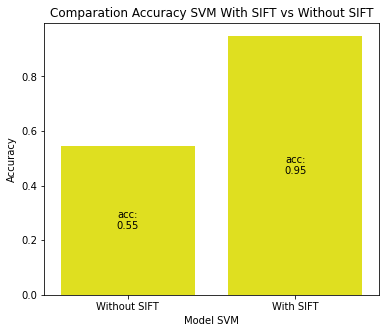

In [183]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.2f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With SIFT vs Without SIFT")

plt.show()

# Predict From Input File

In [ ]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

# Load file ==================================================================================
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image
# ============================================================================================
# Preprocessing Image ========================================================================
def equalizing(img):
    img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

def prep_image(image):
    img = resizing(image, 128)
    img = grayscaling(img)
    img = equalizing(img)
    return img
# ============================================================================================
# Feature Extraction =========================================================================
def extract_sift_descriptor(image):
    sift = cv2.SIFT_create()
    _, descriptor = sift.detectAndCompute(image, None)
    return descriptor

def create_feature_bow(image_descriptor, bow, num_cluster):
    features = np.array([0] * num_cluster, dtype=float)

    if image_descriptor is not None:
        distance = cdist(image_descriptor, bow)
        argmin = np.argmin(distance, axis = 1)
        
        for j in argmin:
            features[j] += 1.0

    return np.array(features)

def extract_feature(image):
    img_descriptor = extract_sift_descriptor(image)
    
    num_cluster = 500
    bow = load_file_pickle(BOW_FILE_PICKLE)
    
    img_feature = create_feature_bow(img_descriptor, bow, num_cluster)
    return img_feature
# ============================================================================================
# Prediction Process =========================================================================
def predict_image(feature):
    scaler = load_file_pickle(SCALER_WS_FILE_PICKLE)
    feature_scale = scaler.transform([feature])
    
    svm_model = load_file_pickle(SVM_WS_FILE_PICKLE)
    result_predict = svm_model.predict(feature_scale)
    return result_predict
# ============================================================================================
# Open widget laod file ======================================================================
def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() 
    root.call('wm', 'attributes', '.', '-topmost', True)
    
    b.files = filedialog.askopenfilename(multiple=True) 
    print(b.files[0])
    processing_files(b.files[0])
# ============================================================================================
# Open widget laod file ======================================================================
def processing_files(file):
    img = import_image(file)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    img = prep_image(img)
    
    img_feature = extract_feature(img)
    result_predict = predict_image(img_feature)
    print("Result Class Prediction :", result_predict)
# ============================================================================================

fileselect = Button(description="File select")
fileselect.on_click(select_files)

display(fileselect)

Button(description='File select', style=ButtonStyle())